In [1]:
!pip install snapatac2 seaborn numpy

import snapatac2 as snap

fragment_file = snap.datasets.pbmc5k()

In [2]:
data = snap.pp.import_data(
    fragment_file,
    chrom_sizes=snap.genome.hg38,
    file=None,
    sorted_by_barcode=False,
)

snap.metrics.tsse(data, snap.genome.hg38)

snap.pp.filter_cells(data, min_counts=5000, min_tsse=10, max_counts=100000)

snap.pp.add_tile_matrix(data)

snap.pp.select_features(data, n_features=250000)

snap.pp.scrublet(data)

snap.pp.filter_doublets(data)

snap.tl.spectral(data)

snap.tl.umap(data)

snap.pp.knn(data)

snap.tl.leiden(data)

/home/shane/.conda/envs/ClusterBuster/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/shane/.conda/envs/ClusterBuster/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2024-01-03 14:21:39 - INFO - Selected 250000 features.
2024-01-03 14:21:40 - INFO - Simulating doublets...
2024-01-03 14:21:40 - INFO - Spectral embedding ...
2024-01-03 14:22:24 - INFO - Calculating doublet scores...
2024-01-03 14:22:26 - INFO - Detected doublet rate = 2.936%
/home/shane/.conda/envs/ClusterBuster/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook

''

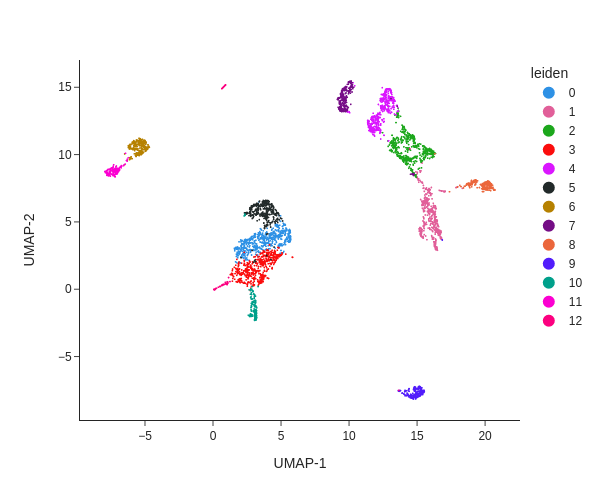

In [3]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

In [4]:
snap.tl.macs3(data, groupby='leiden')

2024-01-03 14:23:10 - INFO - Exporting fragments...
2024-01-03 14:23:25 - INFO - Calling peaks...
100%|██████████| 13/13 [01:59<00:00,  9.17s/it]


In [5]:
data.uns['macs3']['1'].head()

,chrom,start,end,name,score,strand,signal_value,p_value,q_value,peak
0,chr1,10178,10314,.,29,.,3.926603,5.060100,2.957104,72
1,chr1,180772,180972,.,38,.,4.362892,5.954430,3.822648,77
2,chr1,181351,181551,.,56,.,5.235470,7.860990,5.680062,125
3,chr1,191426,191635,.,56,.,5.235470,7.860990,5.680062,65
4,chr1,191716,191989,.,218,.,11.343518,24.252171,21.847006,102


In [6]:
peak_widths = []

for i in data.uns['macs3']:
    
    peak_widths_group = list(
        data.uns['macs3'][i]['end'] - data.uns['macs3'][i]['start']
        )
    
    peak_widths = peak_widths + peak_widths_group

<Axes: ylabel='Density'>

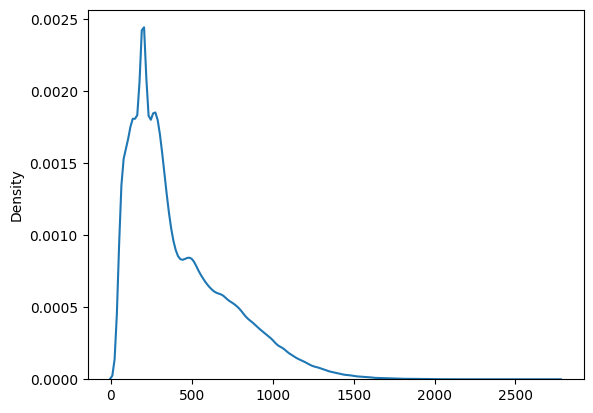

In [7]:
import seaborn as sns

sns.kdeplot(peak_widths)

In [8]:
import numpy as np

print('Average peak width: ' + 
      str(np.mean(peak_widths)) + 
      ' +/- ' + str(np.std(peak_widths)))

Average peak width: 421.2008169146505 +/- 307.7807129623535


In [9]:
consensus_peaks = snap.tl.merge_peaks(data.uns['macs3'], snap.genome.hg38)
consensus_peaks.head()

Peaks,2,5,4,9,1,0,3,11,10,7,12,8,6
str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
"""chr1:10000-105…",false,false,false,false,true,false,false,false,false,false,false,false,false
"""chr1:180607-18…",true,true,false,true,true,true,false,false,true,false,false,false,false
"""chr1:181226-18…",false,false,true,false,true,false,false,false,false,true,false,false,false
"""chr1:191568-19…",false,false,false,true,true,true,true,false,false,false,false,true,false
"""chr1:267735-26…",true,true,false,false,true,true,true,true,true,false,true,true,false


In [10]:
import re

consensus_peaks_list = [re.sub('chr.+:', '', i) for i in consensus_peaks['Peaks'].to_list()]

consensus_peaks_list[:10]


['10000-10501',
 '180607-181108',
 '181226-181727',
 '191568-192069',
 '267735-268236',
 '274152-274653',
 '280431-280932',
 '585947-586448',
 '605345-605846',
 '629731-630232']

In [11]:
consensus_lengths = [abs(eval(i)) for i in consensus_peaks_list]

consensus_lengths[:10]

[501, 501, 501, 501, 501, 501, 501, 501, 501, 501]

In [12]:
print('Average consensus peak width: ' + 
      str(np.mean(consensus_lengths)) + 
      ' +/- ' + str(np.std(consensus_lengths)))

Average consensus peak width: 501.0 +/- 0.0
